In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense,Dropout,LSTM
from  keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from IPython.display import Image, display
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split


from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, DMatrix
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

## Data Extraction

In [3]:
dataframe = pd.read_csv('airbnb_data.csv')
dataframe.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,5456,Guesthouse in Austin · ★4.84 · 1 bedroom · 2 b...,8028,Sylvia,NaN,78702,30.26057,-97.73441,Entire home/apt,126,2,657,2023-08-27,3.72,1,306,42,NaN
1,5769,Home in Austin · ★4.90 · 1 bedroom · 1 bed · 1...,8186,Elizabeth,NaN,78729,30.45697,-97.78422,Private room,45,1,290,2023-08-04,1.77,1,0,21,NaN
2,6413,Guesthouse in Austin · ★4.97 · Studio · 1 bed ...,13879,Todd,NaN,78704,30.24885,-97.73587,Entire home/apt,57,30,122,2022-10-17,0.73,1,0,3,NaN
3,6448,Guesthouse in Austin · ★4.97 · 1 bedroom · 2 b...,14156,Amy,NaN,78704,30.26034,-97.76487,Entire home/apt,159,3,305,2023-09-04,2.09,1,156,17,NaN
4,8502,Guest suite in Austin · ★4.56 · 1 bedroom · 1 ...,25298,Karen,NaN,78741,30.23466,-97.73682,Entire home/apt,48,4,51,2023-05-16,0.31,1,98,3,NaN


In [4]:
dataframe['last_review'] = pd.to_datetime(dataframe['last_review'] , format='%Y-%m-%d')
dataframe['last_review_year'] = dataframe['last_review'].dt.year
dataframe['last_review_month'] = dataframe['last_review'].dt.month
dataframe['last_review_day'] = dataframe['last_review'].dt.day


In [5]:
studio = dataframe[dataframe['name'].str.contains('Studio')].index.tolist()
bedroom = dataframe[dataframe.name.str.contains(r'\bbedrooms?\b')].index.tolist()
bed = dataframe[dataframe.name.str.contains(r'\bbeds?\b')].index.tolist()
bath = dataframe[dataframe.name.str.contains(r'\bbaths?\b')].index.tolist()
rating = dataframe[dataframe.name.str.contains('★')].index.tolist()
shared_bath = dataframe[dataframe.name.str.contains('shared')].index.tolist()
private_bath = dataframe[dataframe.name.str.contains('private')].index.tolist()



In [6]:
import re

def get_data():
    bedrooms_data = {}
    beds_data = {}
    ratings_data = {}
    baths_data = {}
    shared_bath_data = {}
    private_bath_data = {}
    for i, v in enumerate(dataframe['name']):
        bedrooms_data[i] = re.findall(r'\b(\d+)\s+bedrooms?\b', v, flags=re.IGNORECASE)
        beds_data[i] = re.findall(r'\b(\d+)\s+beds?\b', v, flags=re.IGNORECASE)
        ratings_data[i]= re.findall(r'★(?:New|\d+.\d+)\b', v, flags=re.IGNORECASE)
        baths_data[i] = re.findall(r'(\d+)\s+(?:baths?)', v, flags=re.IGNORECASE)
        shared_bath_data[i] = re.findall(r'(\d+)\s+(?:shared?)', v, flags=re.IGNORECASE)
        private_bath_data[i] = re.findall(r'(\d+)\s+(?:private?)', v, flags=re.IGNORECASE)
    bedrooms_data_clean = {key:value for key, value in bedrooms_data.items() if isinstance(value, list) and len(value) > 0}
    beds_data_clean = {key:value for key, value in beds_data.items() if isinstance(value, list) and len(value) > 0}
    ratings_data_clean = {key:value for key, value in ratings_data.items() if isinstance(value, list) and len(value) > 0}
    baths_data_clean = {key:value for key, value in baths_data.items() if isinstance(value, list) and len(value) > 0}
    shared_bath_data_clean = {key:value for key, value in shared_bath_data.items() if isinstance(value, list) and len(value) > 0}
    private_bath_data_clean = {key:value for key, value in private_bath_data.items() if isinstance(value, list) and len(value) > 0}
    return bedrooms_data_clean, beds_data_clean, ratings_data_clean, baths_data_clean, shared_bath_data_clean, private_bath_data_clean

bedrooms_data, beds_data, ratings_data, baths_data, shared_bath_data, private_bath_data = get_data()

In [7]:
def expand_data(df):

    dataframe.insert(1,'inn_name',[value[0] for value in df['name'].str.split(' . ')])
    dataframe.insert(2,'bedrooms', 0)
    dataframe.insert(3,'beds',0)
    dataframe.insert(4,'baths',0)
    dataframe.insert(5, 'studio', 0)
    dataframe.insert(6, 'shared_bath',0)
    dataframe.insert(7, 'private_bath',0)
    dataframe.insert(8, 'ratings',0)

    dataframe.loc[list(bedrooms_data.keys()), 'bedrooms'] = [int(b) for bedroom in bedrooms_data.values() for b in bedroom]
    dataframe.loc[list(beds_data.keys()), 'beds'] = [int(b) for bed in beds_data.values() for b in bed]
    dataframe.loc[list(baths_data.keys()), 'baths'] = [int(b) for bath in baths_data.values() for b in bath]
    dataframe.loc[list(shared_bath_data.keys()), 'baths'] = [int(s) for shared in shared_bath_data.values() for s in shared]
    dataframe.loc[list(shared_bath_data.keys()), 'shared_bath'] = 1
    dataframe.loc[list(private_bath_data.keys()), 'private_bath'] = 1
    dataframe.loc[list(private_bath_data.keys()), 'baths'] = [int(p) for private in private_bath_data.values() for p in private]
    dataframe.loc[list(ratings_data.keys()), 'ratings'] = [r for rating in ratings_data.values() for r in rating]
    dataframe.loc[studio, 'studio'] = 1
    dataframe['ratings'] = dataframe['ratings'].str.replace('★', '').str.replace('New','0').astype(float)
    dataframe['last_review'] = pd.to_datetime(dataframe['last_review'])
    dataframe.drop(columns='name', inplace=True)
    return df

dataframe = expand_data(dataframe)

## Data Validation and Cleansing

In [8]:
dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14861 entries, 0 to 14860
Data columns (total 28 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14861 non-null  int64         
 1   inn_name                        14861 non-null  object        
 2   bedrooms                        14861 non-null  int64         
 3   beds                            14861 non-null  int64         
 4   baths                           14861 non-null  int64         
 5   studio                          14861 non-null  int64         
 6   shared_bath                     14861 non-null  int64         
 7   private_bath                    14861 non-null  int64         
 8   ratings                         10639 non-null  float64       
 9   host_id                         14861 non-null  int64         
 10  host_name                       14859 non-null  object        
 11  ne

In [9]:
missing_counts = dataframe.isnull().sum()
present_values=dataframe.notnull().sum()
unique_value_counts = dataframe.nunique()
total_count = len(dataframe)
missing_percentage= (missing_counts / total_count) * 100
present_percentage= (present_values / total_count) * 100
unique_percentage= (unique_value_counts / total_count) * 100

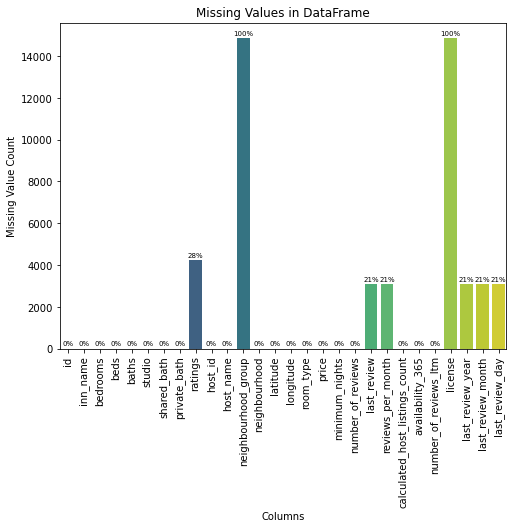

In [10]:
plt.figure(figsize=(8, 6))
ax=sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')

# Add labels and title
plt.title('Missing Values in DataFrame')
plt.xlabel('Columns')
plt.ylabel('Missing Value Count')
plt.xticks(rotation=90)

for p, label in zip(ax.patches, missing_percentage):
    ax.annotate(f'{label:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, 5), textcoords='offset points')

plt.show()

In [11]:
# Checking columns with missing values
missing_cols=missing_counts[missing_counts.values>1000].index.to_list()
missing_cols

['ratings',
 'neighbourhood_group',
 'last_review',
 'reviews_per_month',
 'license',
 'last_review_year',
 'last_review_month',
 'last_review_day']

In [12]:
# Sample of the unique elements of the features
Unique_values_list=[]
for column in dataframe.columns:
    unique_values = dataframe[column].unique().tolist()
    num_unique=dataframe[column].nunique()
    if num_unique==1:
      Unique_values_list.append(column)
    print("{} Unique values in '{}': {} ".format(num_unique,column,unique_values[:5]))
print(Unique_values_list)

14861 Unique values in 'id': [5456, 5769, 6413, 6448, 8502] 
96 Unique values in 'inn_name': ['Guesthouse in Austin', 'Home in Austin', 'Guest suite in Austin', 'Bungalow in Austin', 'Condo in Austin'] 
16 Unique values in 'bedrooms': [1, 0, 2, 3, 5] 
31 Unique values in 'beds': [2, 1, 3, 4, 14] 
12 Unique values in 'baths': [1, 2, 5, 3, 0] 
2 Unique values in 'studio': [0, 1] 
2 Unique values in 'shared_bath': [0, 1] 
2 Unique values in 'private_bath': [0, 1] 
124 Unique values in 'ratings': [4.84, 4.9, 4.97, 4.56, 5.0] 
8834 Unique values in 'host_id': [8028, 8186, 13879, 14156, 25298] 
3415 Unique values in 'host_name': ['Sylvia', 'Elizabeth', 'Todd', 'Amy', 'Karen'] 
0 Unique values in 'neighbourhood_group': [nan] 
44 Unique values in 'neighbourhood': [78702, 78729, 78704, 78741, 78745] 
11670 Unique values in 'latitude': [30.26057, 30.45697, 30.24885, 30.26034, 30.23466] 
11242 Unique values in 'longitude': [-97.73441, -97.78422, -97.73587, -97.76487, -97.73682] 
4 Unique values i

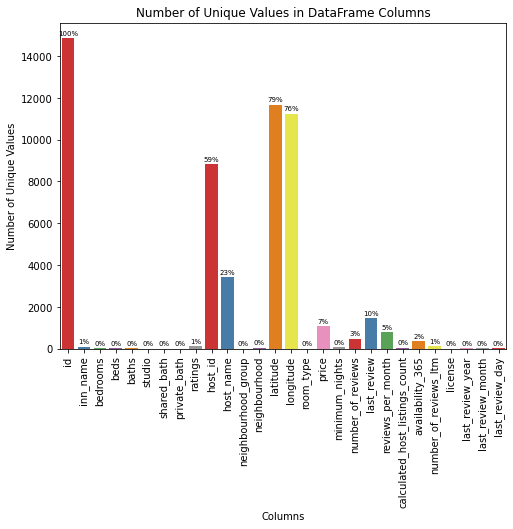

In [13]:
plt.figure(figsize=(8, 6))
ax=sns.barplot(x=unique_value_counts.index, y=unique_value_counts.values, palette='Set1')
plt.title('Number of Unique Values in DataFrame Columns')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.xticks(rotation=90)
for p, label in zip(ax.patches, unique_percentage):
    ax.annotate(f'{label:.0f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', fontsize=7, color='black', xytext=(0, 5), textcoords='offset points')


plt.show()

## Data Aggregation and Representation

In [14]:
dataframe.drop(columns=Unique_values_list, inplace=True)

## Adding an additional variable called holiday or not

# using holidays library to get the holidays
import holidays

holiday_list = list()
print("--- Canada ---")
for date in holidays.Canada(years=[2021,2022,2023], observed=True).items():
    print(str(date[0]), date[1])
    holiday_list.append([date[0], date[1]])
Holiday_dataset=pd.DataFrame(holiday_list,columns=['Date','Holiday'])

Holiday_dataset['Date'] = pd.to_datetime(Holiday_dataset['Date'])


dataframe['last_review_Holiday_or_not'] = dataframe['last_review_day'].apply(lambda x: 1 if x in Holiday_dataset['Date'].dt.day else 0)


--- Canada ---
2021-01-01 New Year's Day
2021-04-02 Good Friday
2021-07-01 Canada Day
2021-09-06 Labour Day
2021-12-25 Christmas Day
2021-12-27 Christmas Day (Observed)
2022-01-01 New Year's Day
2022-01-03 New Year's Day (Observed)
2022-04-15 Good Friday
2022-07-01 Canada Day
2022-09-05 Labour Day
2022-12-25 Christmas Day
2022-12-26 Christmas Day (Observed)
2023-01-01 New Year's Day
2023-01-02 New Year's Day (Observed)
2023-04-07 Good Friday
2023-07-01 Canada Day
2023-09-04 Labour Day
2023-12-25 Christmas Day


## Data Analysis

In [15]:
dataReviews = dataframe.groupby(['inn_name', 'latitude', 'longitude'])[['ratings', 'number_of_reviews', 'number_of_reviews_ltm']].agg({'ratings':'mean', 
                                                                                                                                       'number_of_reviews':'sum',
                                                                                                                                       'number_of_reviews_ltm': 'sum'})

In [16]:
# Summary statistics for numeric columns
summary_stats = dataframe.describe()
summary_stats

,id,bedrooms,beds,baths,studio,shared_bath,private_bath,ratings,host_id,neighbourhood_group,...,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,last_review_year,last_review_month,last_review_day,last_review_Holiday_or_not
count,1.486100e+04,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,14861.000000,10639.000000,1.486100e+04,0.0,...,14861.000000,11758.000000,14861.000000,14861.000000,14861.000000,0.0,11758.000000,11758.000000,11758.000000,14861.000000
mean,3.418962e+17,1.977592,2.643429,2.066415,0.046901,0.071664,0.054774,4.416525,1.455670e+08,NaN,...,37.843348,1.537180,11.047641,152.092591,10.367674,NaN,2022.091767,7.054516,15.691444,0.453940
std,3.952050e+17,1.355601,2.532581,1.524794,0.211435,0.257940,0.227547,1.380964,1.608509e+08,NaN,...,79.894590,1.711574,24.472357,136.610382,17.111299,NaN,1.883346,2.402298,9.449339,0.497891
min,5.456000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.300000e+01,NaN,...,0.000000,0.010000,1.000000,0.000000,0.000000,NaN,2012.000000,1.000000,1.000000,0.000000
25%,2.401701e+07,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,4.710000,1.613528e+07,NaN,...,1.000000,0.260000,1.000000,1.000000,0.000000,NaN,2022.000000,5.000000,6.000000,0.000000
50%,5.176864e+07,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,4.890000,7.039337e+07,NaN,...,8.000000,0.990000,2.000000,127.000000,2.000000,NaN,2023.000000,8.000000,16.000000,0.000000
75%,7.543632e+17,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,4.990000,2.537258e+08,NaN,...,38.000000,2.260000,6.000000,302.000000,14.000000,NaN,2023.000000,9.000000,24.000000,1.000000
max,9.770652e+17,23.000000,132.000000,17.000000,1.000000,1.000000,1.000000,5.000000,5.363086e+08,NaN,...,1141.000000,26.250000,136.000000,365.000000,258.000000,NaN,2023.000000,12.000000,31.000000,1.000000


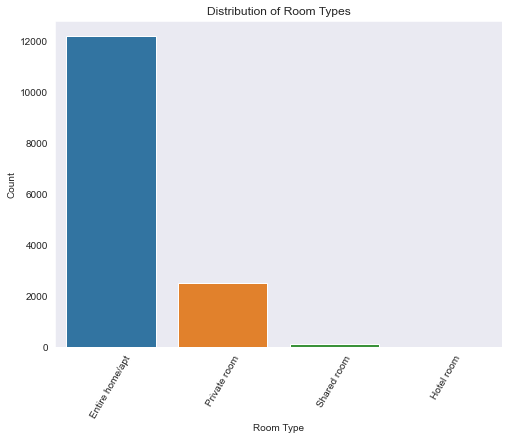

In [17]:
plt.figure(figsize=(8, 6))
sns.color_palette("Spectral", as_cmap=True)
sns.set_style("dark")
sns.countplot(data=dataframe, x='room_type')
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.xticks(rotation=60)
plt.show()

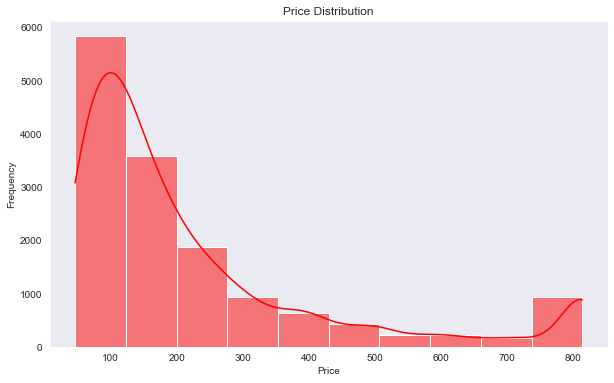

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(dataframe['price'], bins=10, kde=True, color='Red')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

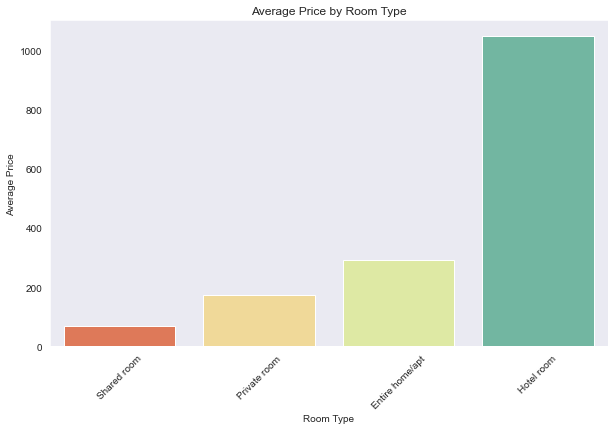

In [19]:
avg_price_by_room_type = dataframe.groupby('room_type')['price'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_by_room_type.index, y=avg_price_by_room_type.values, palette='Spectral')
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

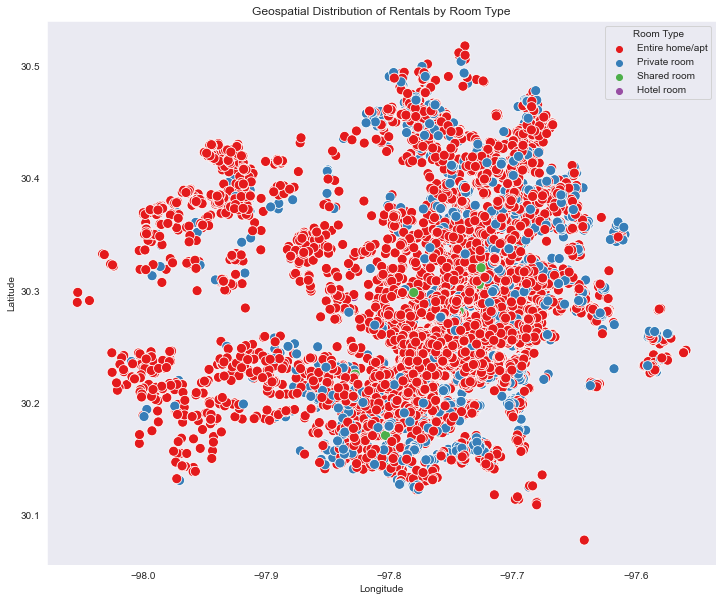

In [20]:
plt.figure(figsize=(12, 10))
sns.scatterplot(data=dataframe, x='longitude', y='latitude', hue='room_type', palette='Set1', s=100)
plt.title('Geospatial Distribution of Rentals by Room Type')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Room Type', loc='upper right')
plt.show()

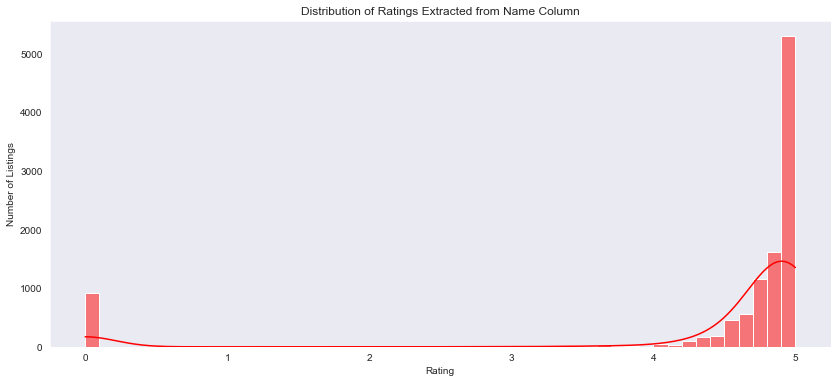

In [44]:

plt.figure(figsize=(14, 6))
sns.histplot(dataframe['ratings'], bins=50, kde=True, color='Red')
plt.title('Distribution of Ratings Extracted from Name Column')
plt.xlabel('Rating')
plt.ylabel('Number of Listings')
plt.show()

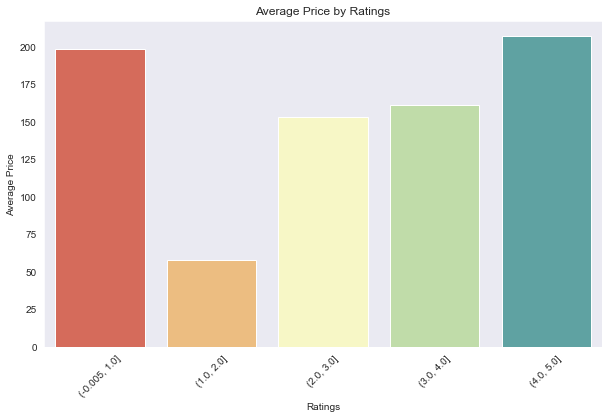

In [51]:
data2=dataframe.copy()
data2['rating_bins']=pd.cut(data2['ratings'],bins=5)

avg_price_by_ratings = data2.groupby('rating_bins')['price'].mean().sort_values()

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_by_ratings.index, y=avg_price_by_ratings.values, palette='Spectral')
plt.title('Average Price by Ratings')
plt.xlabel('Ratings')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

In [21]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14861 entries, 0 to 14860
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14861 non-null  int64         
 1   inn_name                        14861 non-null  object        
 2   bedrooms                        14861 non-null  int64         
 3   beds                            14861 non-null  int64         
 4   baths                           14861 non-null  int64         
 5   studio                          14861 non-null  int64         
 6   shared_bath                     14861 non-null  int64         
 7   private_bath                    14861 non-null  int64         
 8   ratings                         10639 non-null  float64       
 9   host_id                         14861 non-null  int64         
 10  host_name                       14859 non-null  object        
 11  ne

In [22]:
threshold = 0.95
dataframe['price'] = np.clip(dataframe['price'], dataframe['price'].quantile(1 - threshold), dataframe['price'].quantile(threshold))

In [23]:
dataframe_after_dropping=dataframe.drop(['id','inn_name','host_id','host_name','neighbourhood_group','last_review','license'],axis=1)

In [24]:
dataframe_after_dropping=pd.get_dummies(dataframe_after_dropping, prefix=['room_type'])

In [25]:
dataframe_after_dropping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14861 entries, 0 to 14860
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   bedrooms                        14861 non-null  int64  
 1   beds                            14861 non-null  int64  
 2   baths                           14861 non-null  int64  
 3   studio                          14861 non-null  int64  
 4   shared_bath                     14861 non-null  int64  
 5   private_bath                    14861 non-null  int64  
 6   ratings                         10639 non-null  float64
 7   neighbourhood                   14861 non-null  int64  
 8   latitude                        14861 non-null  float64
 9   longitude                       14861 non-null  float64
 10  price                           14861 non-null  float64
 11  minimum_nights                  14861 non-null  int64  
 12  number_of_reviews               

In [26]:
dataframe_after_dropping = dataframe_after_dropping.fillna(dataframe_after_dropping.mean())


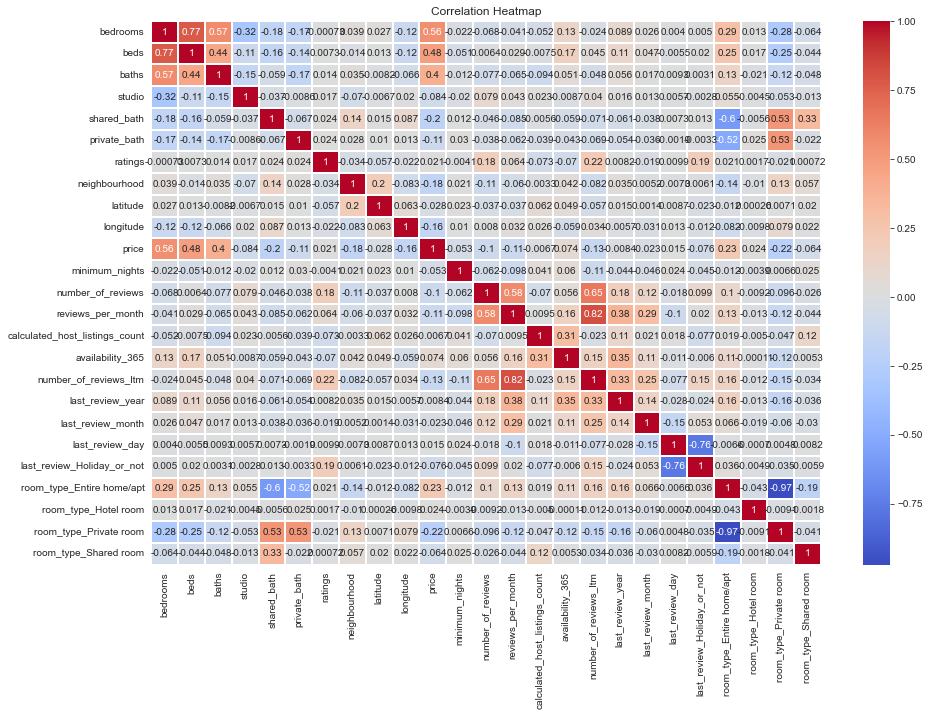

In [27]:
correlation_matrix = dataframe_after_dropping.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.025)

plt.title('Correlation Heatmap')

plt.show()

In [28]:
Y = dataframe_after_dropping.pop('price')
X=dataframe_after_dropping.copy()

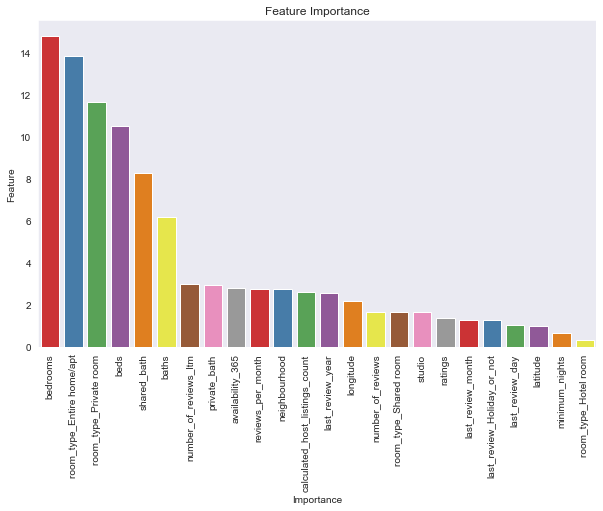

In [29]:
bestfeatures=SelectKBest()
fit=bestfeatures.fit(X,Y)
fit.scores_
#Plotting the feature names and their fit scores
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': fit.scores_})
importances_df = importances_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6) ,)
ax=sns.barplot(x=importances_df['Feature'], y=importances_df['Importance'], palette='Set1')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [31]:
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [32]:
model1=LinearRegression()
model1.fit(X_train,y_train)
print('Train accuracy',model1.score(X_train,y_train))
print('Test accuracy',model1.score(X_test,y_test))

Train accuracy 0.4204269841634434
Test accuracy 0.42890087439167546


In [33]:
baseline_model = DecisionTreeRegressor(max_depth=6)

baseline_model.fit(X_train,y_train)
print('Train accuracy',baseline_model.score(X_train,y_train))
print('Test accuracy',baseline_model.score(X_test,y_test))

Train accuracy 0.5254461592040357
Test accuracy 0.5169482082226587


In [34]:
y_pred = baseline_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)

print('The RMSE score of the decision tree is ',rmse)
print('The MAE score of the decision tree is ',mae)
print('The R2 score of the decision tree is ',r2)
print('The accuracy score of the decision tree is ',baseline_model.score(X_test,y_test)*100)


The RMSE score of the decision tree is  137.0758258436982
The MAE score of the decision tree is  90.81284654172069
The R2 score of the decision tree is  0.5169482082226587
The accuracy score of the decision tree is  51.694820822265875


In [35]:
def train_models(X_train, X_test, y_train, y_test):
    model_dict = {
        "linear": LinearRegression(),
        "Ridge": Ridge(alpha=0.2),
        ##"KNN": KNeighborsRegressor(n_jobs=-1, n_neighbors=4),
        "XGB": XGBRegressor(random_state=42),
       ## "light": LGBMRegressor(random_state=42),
        "Cat": CatBoostRegressor(random_state=42, loss_function='RMSE', verbose=False)
    }
    list1=[]
    dict1={}
    
    
    for model_name, model in model_dict.items() :
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        num_predictors = X_train.shape[1]

        n = X_train.shape[0]

        adjusted_r_squared = 1 - (1 - r2_score(y_test, pred)) * (n - 1) / (n - num_predictors - 1)
        
        print(f"Training loss for model {model_name}   MSE : {mean_squared_error(y_test, pred, squared=False),},RMSE : {sqrt(mean_squared_error(y_test, pred)),}, R-Square : {r2_score(y_test, pred),}, MAE : {mean_absolute_error(y_test, pred),} , Accuracy : {model.score(X_test,y_test)} ,Adjusted R-Square : {adjusted_r_squared}  ")
        dict1[model_name]=[mean_squared_error(y_test, pred),sqrt(mean_squared_error(y_test, pred)),r2_score(y_test, pred),
                           mean_absolute_error(y_test, pred),model.score(X_test,y_test)*100,adjusted_r_squared]
    return dict1

In [36]:
dict1=train_models(X_train, X_test, y_train, y_test)

Training loss for model linear   MSE : (149.04580945548108,),RMSE : (149.04580945548108,), R-Square : (0.42890087439167546,), MAE : (103.32540497081162,) , Accuracy : 0.42890087439167546 ,Adjusted R-Square : 0.42774548545004176  
Training loss for model Ridge   MSE : (149.06963668346668,),RMSE : (149.06963668346668,), R-Square : (0.4287182621221046,), MAE : (103.30624627856334,) , Accuracy : 0.4287182621221046 ,Adjusted R-Square : 0.42756250373813187  
Training loss for model XGB   MSE : (114.25729241647409,),RMSE : (114.25729241647409,), R-Square : (0.6643861987503179,), MAE : (74.27442020075593,) , Accuracy : 0.6643861987503179 ,Adjusted R-Square : 0.663707219467675  
Training loss for model Cat   MSE : (109.99105941116221,),RMSE : (109.99105941116221,), R-Square : (0.6889811398174135,), MAE : (71.65531597845758,) , Accuracy : 0.6889811398174135 ,Adjusted R-Square : 0.6883519184868578  


In [37]:
df = pd.DataFrame(dict1)
df.index = ['MSE', 'RMSE', 'R-Square', 'MAE','Accuracy','Adjusted_r_squared']
df

,linear,Ridge,XGB,Cat
MSE,22214.653316,22221.756581,13054.728870,12098.033150
RMSE,149.045809,149.069637,114.257292,109.991059
R-Square,0.428901,0.428718,0.664386,0.688981
MAE,103.325405,103.306246,74.274420,71.655316
Accuracy,42.890087,42.871826,66.438620,68.898114
Adjusted_r_squared,0.427745,0.427563,0.663707,0.688352


In [38]:
model=CatBoostRegressor(random_state=42, loss_function='RMSE', verbose=False)

model.fit(X_train, y_train)
pred = model.predict(X_test)

rmse = sqrt(mean_squared_error(y_test, y_pred))

mae = mean_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)

print('The RMSE score of the decision tree is ',rmse)
print('The MAE score of the decision tree is ',mae)
print('The R2 score of the decision tree is ',r2)
print('The accuracy score of the decision tree is ',model.score(X_test,y_test)*100)


The RMSE score of the decision tree is  137.0758258436982
The MAE score of the decision tree is  90.81284654172069
The R2 score of the decision tree is  0.5169482082226587
The accuracy score of the decision tree is  68.89811398174135


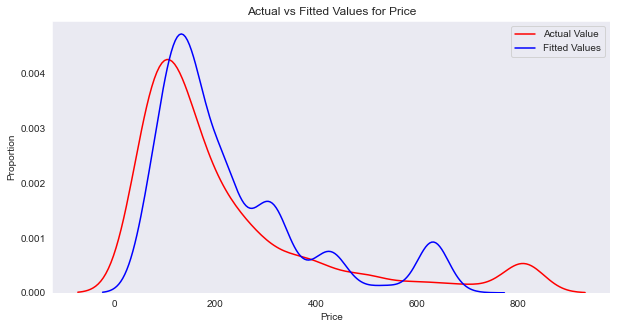

In [39]:
test_plot=pd.DataFrame()
test_plot['Actual_price']=y_test
test_plot['predicted_price']=y_pred
plt.figure(figsize=(10, 5))
ax1 = sns.distplot(test_plot['Actual_price'], hist=False, color="r", label="Actual Value")
sns.distplot(test_plot['predicted_price'], hist=False, color="b", label="Fitted Values" , ax=ax1)


plt.title('Actual vs Fitted Values for Price')
plt.xlabel('Price')
plt.ylabel('Proportion')
plt.legend()
plt.show()
plt.close()

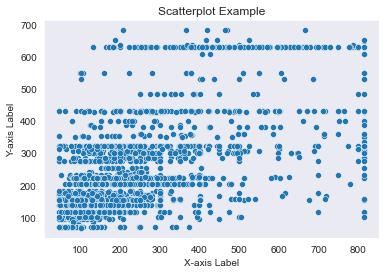

In [40]:
sns.scatterplot(x=test_plot['Actual_price'], y=test_plot['predicted_price'])

# Optionally, you can set labels for the axes and a title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatterplot Example')

# Show the plot
plt.show()